In [14]:
import gc
import os

import pandas as pd

import torch
import numpy as np
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.model_selection import train_test_split
from torch.nn.functional import normalize
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics


In [15]:
def to_torch(X, d_type: torch.dtype):
    m, n = X.shape[0], X.shape[1]
    X_inner = torch.tensor(X, dtype=d_type)

    X_prime = normalize(torch.cat(
        [X_inner, torch.ones(m, dtype=d_type).reshape(-1, 1)], dim=1
    ), p=2, dim=1)
    return X_prime


In [16]:
def kronecker(a: torch.Tensor, b: torch.Tensor):
    return torch.einsum('na,nb->nab', a, b).view(a.size(0), a.size(1) * b.size(1))


In [17]:
if not os.path.exists('./bc_output'):
        os.mkdir('./bc_output')

In [5]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64

    X, y = load_breast_cancer(return_X_y=True)

    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)

    X_prime = to_torch(X_train, d_type=d_type)

    test_class = 0
    test_no = 1
    X_test_prime = to_torch(X_test[y_test == test_class], d_type=d_type)

    max_copies = 100
    result = []
    for copies in range(1, max_copies + 1):
        c = X_test_prime[test_class]
        result_sum = 0
        result_sum_fid = 0
        for a_index in range(X_prime[y_train == 0].shape[0]):
            for b_index in range(X_prime[y_train == 1].shape[0]):
                a = X_prime[y_train == 0][a_index]
                b = X_prime[y_train == 1][b_index]

                inner_product_ab: torch.Tensor = torch.matmul(a, b)
                inner_product_ca: torch.Tensor = torch.matmul(c, a)
                inner_product_cb: torch.Tensor = torch.matmul(c, b)
                overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                contrib_ca = np.power(overlap_ca, copies)
                contrib_cb = np.power(overlap_cb, copies)

                result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                result_ab_fid = contrib_ca - contrib_cb
                result_sum += result_ab
                result_sum_fid += result_ab_fid
                
    
        result_sum = result_sum / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
        result_sum_fid = result_sum_fid / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
        
        df_copies = pd.DataFrame(
            data=[[copies, result_sum, result_sum_fid]],
            columns=['Copies', 'Helstrom sim', 'Fidelity sim']
        )
        result.append(df_copies)
        df = pd.concat(result)

df.to_csv(f'./bc_output/bc_score_copies_{max_copies}.csv')   


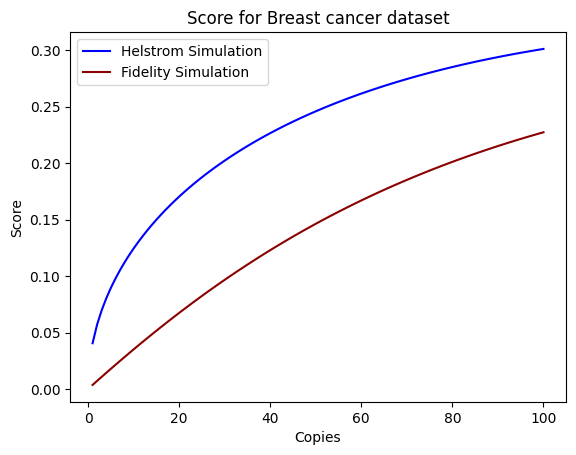

In [6]:
df = pd.read_csv(f'./bc_output/bc_score_copies_{max_copies}.csv')
fig: Figure = plt.figure()
ax: Axes = fig.subplots()
df.plot(x='Copies', y='Helstrom sim', kind='line', ax=ax, label='Helstrom Simulation', color='blue')
df.plot(x='Copies', y='Fidelity sim', kind='line', ax=ax, label='Fidelity Simulation', color='darkred')
ax.set_ylabel('Score')
plt.legend()
plt.title("Score for Breast cancer dataset")
plt.savefig(f'./bc_output/scoare_test_{test_class}_{max_copies}.png')
plt.savefig(f'./bc_output/score_test_{test_class}_{max_copies}.pdf')
plt.show()

In [ ]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64

    X, y = load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)
    X_prime = to_torch(X_train, d_type=d_type)

    test_class = 0
    test_no = 1
    X_test_prime = to_torch(X_test, d_type=d_type)


    max_copies = 100
    result_sum = torch.zeros(X_test_prime.shape[0])
    result_sum_fid = torch.zeros(X_test_prime.shape[0])
    accuracy = torch.zeros(max_copies)
    accuracy_fid = torch.zeros(max_copies)
    
    for copies in range(1,max_copies+1):
        for i in range(X_test_prime.shape[0]):
            c = X_test_prime[i] 
            for a_index in range(X_prime[y_train == 0].shape[0]):
                for b_index in range(X_prime[y_train == 1].shape[0]):
                    a = X_prime[y_train == 0][a_index]
                    b = X_prime[y_train == 1][b_index]

                    inner_product_ab: torch.Tensor = torch.matmul(a, b)
                    inner_product_ca: torch.Tensor = torch.matmul(c, a)
                    inner_product_cb: torch.Tensor = torch.matmul(c, b)
                    overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                    overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                    overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                    lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                    contrib_ca = np.power(overlap_ca, copies)
                    contrib_cb = np.power(overlap_cb, copies)
    
                    result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                    result_ab_fid = contrib_ca - contrib_cb
                    result_sum[i] += result_ab
                    result_sum_fid[i] += result_ab_fid
            
            result_sum[i] = result_sum[i] / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
            result_sum_fid[i] = result_sum_fid[i] / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
            
            
            if result_sum[i] > 0:
                result_sum[i] = 0
            else:
                result_sum[i] = 1
            
            if result_sum_fid[i] > 0:
                result_sum_fid[i] = 0
            else:
                result_sum_fid[i] = 1
    
        
        accuracy[copies-1] = metrics.accuracy_score(y_test, result_sum, normalize=True, sample_weight=None)
        accuracy_fid[copies-1] = metrics.accuracy_score(y_test, result_sum_fid, normalize=True, sample_weight=None) 

In [ ]:
copies = torch.zeros(max_copies)
for i in range(max_copies):
    copies[i] = i+1

d = {'copies' : copies, 'accuracy' : accuracy, 'accuracy_fid': accuracy_fid}
df = pd.DataFrame(data = d)
df.to_csv(f'./bc_output/bc_accuracy_copies_{max_copies}.csv')   

In [ ]:
df = pd.read_csv(f'./bc_output/bc_accuracy_copies_{max_copies}.csv')
fig: Figure = plt.figure()
ax: Axes = fig.subplots()
df.plot(x='copies', y='accuracy', kind='line', ax=ax, label='Helstrom Simulation', color='blue')
df.plot(x='copies', y='accuracy', kind='line', ax=ax, label='Fidelity Simulation', color='red')
ax.set_ylabel('accuracy')
plt.legend()
plt.title("accuracy for Breast Cancer dataset")
plt.savefig(f'./bc_output/bc_accuracy_test_{max_copies}.png')
plt.savefig(f'./bc_output/bc_accuracy_test_{max_copies}.pdf')
plt.show()

In [ ]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64


    X, y = load_breast_cancer(return_X_y=True)

    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)

    X_prime = to_torch(X_train, d_type=d_type)

    test_no = 10
    X_test_prime = to_torch(X_test, d_type=d_type)

    copies = 10
    result_sum = torch.zeros(X_test_prime.shape[0])
    result_sum_fid = torch.zeros(X_test_prime.shape[0])
    
    for i in range(X_test_prime.shape[0]):
        c = X_test_prime[i] 
        for a_index in range(X_prime[y_train == 0].shape[0]):
            for b_index in range(X_prime[y_train == 1].shape[0]):
                a = X_prime[y_train == 0][a_index]
                b = X_prime[y_train == 1][b_index]

                inner_product_ab: torch.Tensor = torch.matmul(a, b)
                inner_product_ca: torch.Tensor = torch.matmul(c, a)
                inner_product_cb: torch.Tensor = torch.matmul(c, b)
                overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                contrib_ca = np.power(overlap_ca, copies)
                contrib_cb = np.power(overlap_cb, copies)

                result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                result_ab_fid = contrib_ca - contrib_cb
                result_sum[i] += result_ab
                result_sum_fid[i] += result_ab_fid
                
    
result_sum = result_sum / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
result_sum_fid = result_sum_fid / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])

In [ ]:
copies = 10
df = pd.read_csv(f'./bc_output/classification_test_copies_{copies}.csv')
result_sum10 = df['result_sum']
result_sum_fid10 = df['result_sum_fid']

hel_pred = np.zeros(X_test_prime.shape[0])
fid_pred = np.zeros(X_test_prime.shape[0])

for i in range(X_test_prime.shape[0]):
    if result_sum10[i] > 0:
        hel_pred[i] = 0
    else:
        hel_pred[i] = 1

for i in range(X_test_prime.shape[0]):
    if result_sum_fid10[i] > 0:
        fid_pred[i] = 0
    else:
        fid_pred[i] = 1

print("helstrom for copies:{:} \n".format(copies))        
print(metrics.classification_report(y_test, hel_pred, digits=3))
print(metrics.confusion_matrix(y_test, hel_pred))

print("helstrom for copies:{:} \n".format(copies))        
print(metrics.classification_report(y_test, fid_pred, digits=3))
print(metrics.confusion_matrix(y_test, fid_pred))

helstrom for copies:10 

              precision    recall  f1-score   support

           0      0.917     0.892     0.904        37
           1      0.949     0.961     0.955        77

    accuracy                          0.939       114
   macro avg      0.933     0.926     0.929       114
weighted avg      0.938     0.939     0.938       114

[[33  4]
 [ 3 74]]
helstrom for copies:10 

              precision    recall  f1-score   support

           0      0.971     0.892     0.930        37
           1      0.950     0.987     0.968        77

    accuracy                          0.956       114
   macro avg      0.960     0.939     0.949       114
weighted avg      0.957     0.956     0.956       114

[[33  4]
 [ 1 76]]


In [ ]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64


    X, y = load_breast_cancer(return_X_y=True)

    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)

    X_prime = to_torch(X_train, d_type=d_type)

    test_no = 10
    X_test_prime = to_torch(X_test, d_type=d_type)

    copies = 50
    result_sum = torch.zeros(X_test_prime.shape[0])
    result_sum_fid = torch.zeros(X_test_prime.shape[0])
    
    for i in range(X_test_prime.shape[0]):
        c = X_test_prime[i] 
        for a_index in range(X_prime[y_train == 0].shape[0]):
            for b_index in range(X_prime[y_train == 1].shape[0]):
                a = X_prime[y_train == 0][a_index]
                b = X_prime[y_train == 1][b_index]

                inner_product_ab: torch.Tensor = torch.matmul(a, b)
                inner_product_ca: torch.Tensor = torch.matmul(c, a)
                inner_product_cb: torch.Tensor = torch.matmul(c, b)
                overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                contrib_ca = np.power(overlap_ca, copies)
                contrib_cb = np.power(overlap_cb, copies)

                result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                result_ab_fid = contrib_ca - contrib_cb
                result_sum[i] += result_ab
                result_sum_fid[i] += result_ab_fid
                
    
result_sum = result_sum / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
result_sum_fid = result_sum_fid / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])

In [ ]:
df = pd.DataFrame(np.asarray([
            result_sum.numpy().T,
            result_sum_fid.numpy(),
            y_test
        ]).T, columns=['result_sum', 'result_sum_fid', 'y_test'])
df.to_csv(f'./bc_output/classification_test_copies_{copies}.csv')

In [ ]:
copies = 50
df = pd.read_csv(f'./bc_output/classification_test_copies_{copies}.csv')
result_sum50 = df['result_sum']
result_sum_fid50 = df['result_sum_fid']

In [ ]:
hel_pred = np.zeros(X_test_prime.shape[0])
fid_pred = np.zeros(X_test_prime.shape[0])

for i in range(X_test_prime.shape[0]):
    if result_sum50[i] > 0:
        hel_pred[i] = 0
    else:
        hel_pred[i] = 1

for i in range(X_test_prime.shape[0]):
    if result_sum_fid50[i] > 0:
        fid_pred[i] = 0
    else:
        fid_pred[i] = 1


In [ ]:
print("helstrom for copies:{:} \n".format(copies))        
print(metrics.classification_report(y_test, hel_pred, digits=3))
print(metrics.confusion_matrix(y_test, hel_pred))

print("helstrom for copies:{:} \n".format(copies))        
print(metrics.classification_report(y_test, fid_pred, digits=3))
print(metrics.confusion_matrix(y_test, fid_pred))

helstrom for copies:50 

              precision    recall  f1-score   support

           0      0.917     0.892     0.904        37
           1      0.949     0.961     0.955        77

    accuracy                          0.939       114
   macro avg      0.933     0.926     0.929       114
weighted avg      0.938     0.939     0.938       114

[[33  4]
 [ 3 74]]
helstrom for copies:50 

              precision    recall  f1-score   support

           0      0.943     0.892     0.917        37
           1      0.949     0.974     0.962        77

    accuracy                          0.947       114
   macro avg      0.946     0.933     0.939       114
weighted avg      0.947     0.947     0.947       114

[[33  4]
 [ 2 75]]


0      0.758911
1      0.810478
2      0.698054
3      0.815323
4      0.377121
         ...   
109    0.617813
110    0.261623
111    0.821414
112    0.760103
113    0.797756
Name: result_sum, Length: 114, dtype: float64

0      0.758911
1      0.810478
2      0.698054
3      0.815323
4      0.377121
         ...   
109    0.617813
110    0.261623
111    0.821414
112    0.760103
113    0.797756
Name: result_sum, Length: 114, dtype: float64

0      0.758911
1      0.810478
2      0.698054
3      0.815323
4      0.377121
         ...   
109    0.617813
110    0.261623
111    0.821414
112    0.760103
113    0.797756
Name: result_sum, Length: 114, dtype: float64

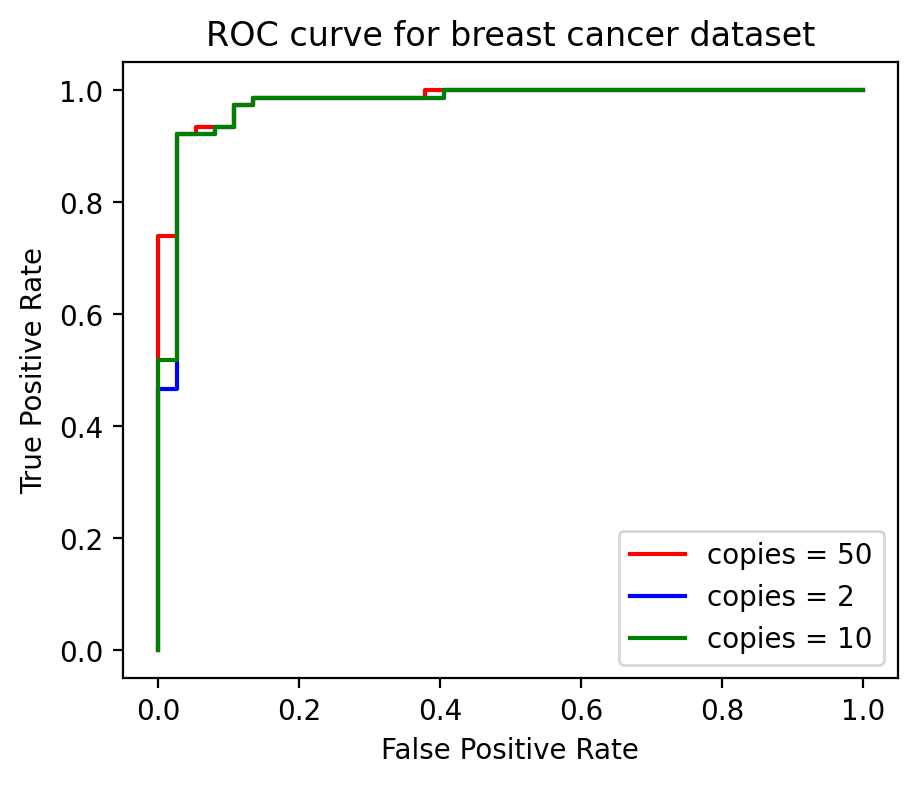

In [ ]:
hel_prob50 = (1-result_sum50)/2
display(hel_prob)
fpr50, tpr50, _ = metrics.roc_curve(y_test, hel_prob50)

hel_prob10 = (1-result_sum10)/2
display(hel_prob)
fpr10, tpr10, _ = metrics.roc_curve(y_test, hel_prob10)

hel_prob2 = (1-result_sum2)/2
display(hel_prob)
fpr2, tpr2, _ = metrics.roc_curve(y_test, hel_prob2)

plt.figure(figsize=(5,4), dpi=200)
plt.plot(fpr50,tpr50, 'r', label = 'copies = 50')
plt.plot(fpr2,tpr2, 'b', label = 'copies = 2')
plt.plot(fpr10, tpr10, 'g', label = 'copies = 10')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title("ROC curve for breast cancer dataset")
plt.savefig(f'./bc_output/bc_roc_curve.png')
plt.savefig(f'./bc_output/bc_roc_curve.pdf')
plt.show()

